In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
print("pytorch ver . ",torch.__version__)
print("Is CUDA available?",torch.cuda.is_available())
import torch.nn as nn
import torch.optim as optim

pytorch ver .  1.11.0+cu113
Is CUDA available? True


/home/luhung3080/miniconda3/envs/chou/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Read data

In [2]:
data=pd.read_csv('/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/data_final.csv')

# Generate X Y 

In [3]:
###
#cal_PMf  
###
u=np.zeros([605,5112])
for i in range (0,605):
    a=np.array(data['pm25_cal'][5112*i:5112*i+5112])
    u[i]=a.T

###
#obs_PMf
###
v=np.zeros([605,5112])
for i in range (0,605):
    a=np.array(data['pm25_obs'][5112*i:5112*i+5112])
    v[i]=a.T

print(np.shape(u))
print(np.shape(v))

(605, 5112)
(605, 5112)


In [4]:
XRestruct_Fun=u
YRestruct_Fun=v
print(np.shape(XRestruct_Fun))
print(np.shape(YRestruct_Fun))

(605, 5112)
(605, 5112)


In [5]:
Xhat=XRestruct_Fun
Yhat=YRestruct_Fun
Xhat_train = np.zeros([544,5112])
Yhat_train = np.zeros([544,5112])
Xhat_test = np.zeros([61,5112])
Yhat_test = np.zeros([61,5112])
for i in range (0,544):
    for j in range (0,5112):
        Xhat_train[i][j] = Xhat[i][j]
        Yhat_train[i][j] = Yhat[i][j]
for i in range (544,605):
    for j in range (0,5112):
        Xhat_test[i-544][j] = Xhat[i][j]
        Yhat_test[i-544][j] = Yhat[i][j]
        
print('Xhat_train')
#print(Xhat_train)
print(np.shape(Xhat_train))
print('Yhat_train')
#print(Yhat_train)
print(np.shape(Yhat_train))
print('Xhat_test')
#print(Xhat_test)
print(np.shape(Xhat_test))
print('Yhat_test')
#print(Yhat_test)
print(np.shape(Yhat_test))

Xhat_train
(544, 5112)
Yhat_train
(544, 5112)
Xhat_test
(61, 5112)
Yhat_test
(61, 5112)


# Modeling

In [6]:
x = Xhat_train
y = Yhat_train
xt = Xhat_test
yt = Yhat_test

In [7]:
def model (x,b0,b1):
    y = b0 + b1*x
    return y

In [ ]:
features = torch.from_numpy(x)
targets = torch.from_numpy(y)
x_test = torch.from_numpy(xt)
y_test = torch.from_numpy(yt)

beta0 = torch.ones(5112, requires_grad = True)
beta1 = torch.ones(5112, requires_grad = True)

rate = 1e-2
optimizer = optim.Adam([beta0 , beta1], lr=rate)

epo = 2001
loss = nn.L1Loss()
train_error1 = np.zeros(epo)
test_error1 = np.zeros(epo)


for epoch in range (epo):
    yhats_train = model(features.float() , beta0 , beta1)
    train_loss = loss(targets.float() , yhats_train)
    train_error1[epoch] = train_loss

    optimizer.zero_grad()
    train_loss.backward() 
    optimizer.step()    

    yhats_test = model(x_test.float(), beta0, beta1) 
    r = abs(yhats_test - y_test)
    test_loss = torch.nanmean(r)
    test_error1[epoch] = test_loss

    if epoch <= 10 or epoch % 10 == 0:
        print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                    f" Testing loss {test_loss.item():.4f}")
    else :
        if epoch >= epo-10 :
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                        f" Testing loss {test_loss.item():.4f}")

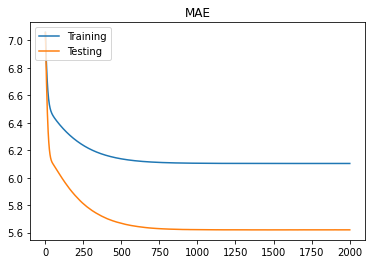

In [9]:
fig1 = plt.figure(1)
x=np.linspace(1,epo,epo)
plt.plot(x,train_error1, label = 'Training')
plt.plot(x,test_error1, label ='Testing')
plt.legend(loc = 2)
plt.title('MAE')

plt.show()

In [10]:
print(np.min(test_error1))

5.619952320605696


# Use LBFGS optimizer

In [11]:
x = Xhat_train
y = Yhat_train
xt = Xhat_test
yt = Yhat_test

In [12]:
def model (x,b0,b1):
    # y = b0 +  torch.matmul(x,b1)
    y = b0 + b1*x
    return y

In [ ]:
features = torch.from_numpy(x)
targets = torch.from_numpy(y)
x_test = torch.from_numpy(xt)
y_test = torch.from_numpy(yt)

beta0 = torch.ones(5112 , requires_grad = True)
beta1 = torch.ones(5112 , requires_grad = True)

rate = 1e-2
optimizer = optim.LBFGS([beta0 , beta1] , lr = rate)

epo = 201
loss = nn.MSELoss()
train_error2 = np.zeros(epo)
test_error2 = np.zeros(epo)


for epoch in range (epo):

    def closure():
        yhats_train = model(features.float() , beta0 , beta1)
        train_loss = loss(targets.float() , yhats_train)
        train_error2[epoch] = train_loss
        optimizer.zero_grad()
        train_loss.backward(retain_graph=True) 
        return train_loss
    
    optimizer.step(closure)   
    yhats_test = model(x_test.float(), beta0, beta1) 
    r = torch.abs(yhats_test - y_test)
    test_loss = torch.nanmean(r)
    test_error2[epoch] = test_loss

    if epoch <= 10 or epoch % 10 == 0:
        print(f"Epoch {epoch}, Training loss {train_error2[epoch]:.4f},"
                    f" Testing loss {test_error2[epoch]:.4f}")

    else :
        if epoch >= epo-10 :
            print(f"Epoch {epoch}, Training loss {train_error2[epoch]:.4f},"
                    f" Testing loss {test_error2[epoch]:.4f}")

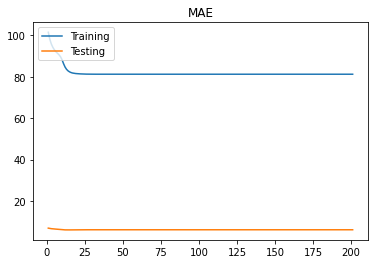

In [14]:
fig1 = plt.figure(1)
x=np.linspace(1,epo,epo)
plt.plot(x,train_error2, label = 'Training')
plt.plot(x,test_error2, label ='Testing')
plt.legend(loc = 2)
plt.title('MAE')

plt.show()

In [15]:
print(np.min(test_error2))

6.061861967280766


# Result

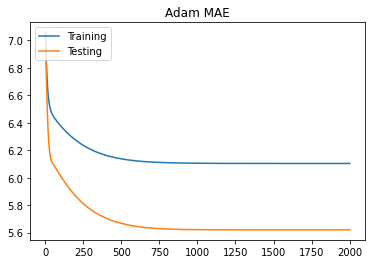

In [16]:
fig1 = plt.figure(1)
x=np.linspace(1,2001,2001)
plt.plot(x,train_error1, label = 'Training')
plt.plot(x,test_error1, label ='Testing')
plt.legend(loc = 2)
plt.title('Adam MAE')

plt.show()

In [17]:
print('Adam MAE : ', np.min(test_error1))

Adam MAE :  5.619952320605696


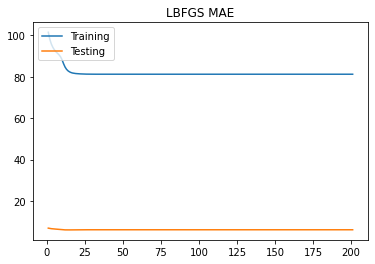

In [18]:
fig1 = plt.figure(1)
x=np.linspace(1,201,201)
plt.plot(x,train_error2, label = 'Training')
plt.plot(x,test_error2, label ='Testing')
plt.legend(loc = 2)
plt.title('LBFGS MAE')

plt.show()

In [19]:
print('LBFGS MAE : ', np.min(test_error2))

LBFGS MAE :  6.061861967280766
